# Rules Based ChatBot : "AirBOT" from Lallemand Flavien & Deffontaines Germain

In [95]:
# install the diffetents libraries

In [96]:
!pip install stop_words

In [97]:
!pip install wordcloud

In [98]:
!pip install gensim

In [99]:
! pip install pyLDAvis

In [100]:
#import all libraries that we need

import pandas as pd
import contractions
import re
import nltk
import string
from nltk.tokenize import  word_tokenize
import numpy as np
from stop_words import get_stop_words
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import gensim.corpora as corpora
from pprint import pprint
import gensim
import pickle 
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances


In [101]:
# load the Q&A csv
df = pd.read_csv('question_responce.csv')	

In [102]:
# quick look of the csv
df.head()

,Unnamed: 0,responce,question
0,603,@115904 We'll be sure to pass along your kind ...,@AmericanAir Erica on the lax team is amazing ...
1,605,@115904 Our apologies for the delay in respond...,@AmericanAir Could you have someone on your la...
2,608,"@115905 Aww, that's definitely a future pilot ...",Ben Tennyson and an American Airlines pilot. 🎃...
3,612,@115906 We're sorry for your frustration.,"@AmericanAir Right, but I earned those. I also..."
4,618,@115909 We're glad you got to kick back and en...,"Thank you, @AmericanAir for playing #ThisIsUs ..."


## Preprocessing of the csv

In [103]:
#preprocessing functions


def remove_punctuation(word_list):
    PUNCUATION_LIST = list(string.punctuation)
    return [w for w in word_list if w not in PUNCUATION_LIST]


def preproc_pipe(data):
    
    data = data.dropna()
    data_clean = pd.DataFrame()
    data_clean['text'] = data
    
    #text to lowercase
    data_clean['text'] = data_clean['text'].str.lower()

    #remove URL links
    data_clean['text'] = data_clean['text'].apply(lambda x: re.sub(r'https?:\/\/\S+', '', x))
    data_clean['text'].apply(lambda x: re.sub(r"www\.[a-z]?\.?(com)+|[a-z]+\.(com)", '', x))

    #remove placeholders
    data_clean['text'] = data_clean['text'].apply(lambda x: re.sub(r'{link}', '', x))
    data_clean['text'] = data_clean['text'].apply(lambda x: re.sub(r"\[video\]", '', x))

    #remove HTML reference characters
    data_clean['text'] = data_clean['text'].apply(lambda x: re.sub(r'&[a-z]+;', '', x))

    #remove handles
    data_clean['text'] = data_clean['text'].apply(lambda x: re.sub(r"@([a-zA-Z0-9_]{1,50})","", x))

    #remove non-letter characters
    data_clean['text'] = data_clean['text'].apply(lambda x: re.sub(r"[^a-z\s\(\-:\)\\\/\];='#]", '', x))

    # Replace contractions with their longer forms 
    data_clean['text'] = data_clean['text'].apply(lambda x:  contractions.fix(x))



    #tokenize
    data_clean['tokens'] = data_clean['text'].apply(nltk.word_tokenize)

    #remove punctuation
    data_clean['tokens'] = data_clean['tokens'].apply(remove_punctuation)


    #remove stopwords
    stop_words = list(get_stop_words('en'))         #About 900 stopwords
    nltk_words = list(stopwords.words('english')) #About 150 stopwords
    stop_words.extend(nltk_words)

    data_clean['tokens'] = data_clean['tokens'].apply(lambda x: [w for w in x if w not in stop_words])

    #stemming/lemmatization

      
    lemmatizer = WordNetLemmatizer()
    data_clean['tokens'] = data_clean['tokens'].apply(lambda x: [lemmatizer.lemmatize(w) for w in x])

    #remove non english word
    return data_clean



In [104]:
# call of the preprocess/tokenize function
df[['responce_clean','token_responce']] = preproc_pipe(df['responce'])
df[['question_clean','token_question']] = preproc_pipe(df['question'])

In [105]:
#Quick look of the dataframe
df.head()

,Unnamed: 0,responce,question,responce_clean,token_responce,question_clean,token_question
0,603,@115904 We'll be sure to pass along your kind ...,@AmericanAir Erica on the lax team is amazing ...,we will be sure to pass along your kind words...,"[sure, pas, along, kind, word, aateam]",erica on the lax team is amazing give her a r...,"[erica, lax, team, amazing, give, raise, ty]"
1,605,@115904 Our apologies for the delay in respond...,@AmericanAir Could you have someone on your la...,our apologies for the delay in responding to ...,"[apology, delay, responding, made, lax, let, u...",could you have someone on your lax team avail...,"[someone, lax, team, available, guide, gate, s..."
2,608,"@115905 Aww, that's definitely a future pilot ...",Ben Tennyson and an American Airlines pilot. 🎃...,aww that is definitely a future pilot in the ...,"[aww, definitely, future, pilot, making, happy...",ben tennyson and an american airlines pilot #...,"[ben, tennyson, american, airline, pilot, trun..."
3,612,@115906 We're sorry for your frustration.,"@AmericanAir Right, but I earned those. I also...",we are sorry for your frustration,"[sorry, frustration]",right but i earned those i also should not ha...,"[right, earned, also, pay, pas, spouse, need, ..."
4,618,@115909 We're glad you got to kick back and en...,"Thank you, @AmericanAir for playing #ThisIsUs ...",we are glad you got to kick back and enjoy a ...,"[glad, got, kick, back, enjoy, show, flying, t...",thank you for playing #thisisus and for havin...,"[thank, playing, thisisus, great, flight, atte..."


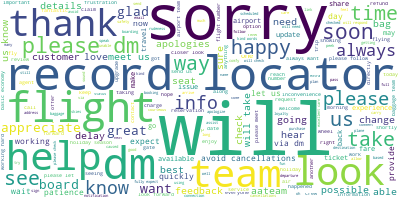

In [106]:
# Visualise word cloud to have a quick look of the differents vocans terms for the responces part

long_string = ','.join(list(df['responce_clean'].values))# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')# Generate a word cloud
wordcloud.generate(long_string)# Visualize the word cloud
wordcloud.to_image()

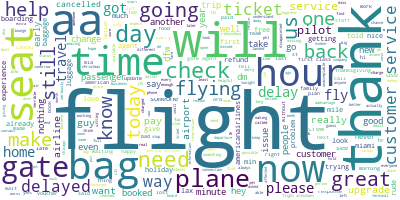

In [107]:
# Visualise word cloud to have a quick look of the differents vocans terms for the questions part

long_string = ','.join(list(df['question_clean'].values))# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')# Generate a word cloud
wordcloud.generate(long_string)# Visualize the word cloud
wordcloud.to_image()

## TOPIC MODELING LDA

In [108]:
#creation of the dictonary of topics
data_words = df['token_question']
id2word = corpora.Dictionary(data_words)# Create Corpus
for i in id2word.values():
    print(i)

amazing
erica
give
lax
raise
team
ty
available
gate
guide
possible
someone
soon
airline
american
ben
diycostume
halloween
parenting
pilot
tennyson
trunkortreat
also
change
earned
need
pas
pay
program
right
spouse
attendant
back
flight
great
home
playing
thank
thisisus
's
aa
amtrak
decent
free
least
look
make
price
pro
reasonable
wifi
admiral
ca
club
francisco
san
wonderful
already
browser
didchanged
hour
reservation
still
techie
trick
booking
frustrating
made
payso
stillonholdthey
trying
/person
additional
cost
paybecause
ticket
told
waitomg
well
booked
farethat
finally
honored
line
lower
help
much
airport
gone
long
able
big
guacamole
lounge
margs
nomnom
thanks
underway
upgrade
god
going
minute
oh
ten
addition
credit
go
grief
outstanding
poorly
thing
aware
chck
empty
fit
flt
luggage
ok
overhead
overheadthis
pre-security
return
trip
b
charged
check
despite
ewr
flying
forced
full
guitar
mia
security
w/
business
class
fifteen
got
notreat
one
person
seat
thentrickitis
upgraded
weak
yo
ago


In [109]:
texts = data_words# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)]


In [110]:

num_topics = 20# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.013*"bag" + 0.011*"way" + 0.009*"great" + 0.008*"know" + 0.007*"u" + '
  '0.007*"flight" + 0.006*"hour" + 0.006*"get" + 0.006*"ticket" + 0.006*"aa"'),
 (1,
  '0.044*"flight" + 0.011*"first" + 0.009*"hour" + 0.008*"get" + '
  '0.008*"delayed" + 0.008*"class" + 0.007*"time" + 0.006*"customer" + '
  '0.006*"want" + 0.006*"booked"'),
 (2,
  '0.034*"flight" + 0.022*"seat" + 0.013*"get" + 0.008*"back" + 0.008*"gate" + '
  '0.007*"thanks" + 0.006*"please" + 0.006*"home" + 0.006*"check" + '
  '0.005*"plane"'),
 (3,
  '0.021*"get" + 0.016*"flight" + 0.013*"bag" + 0.008*"aa" + 0.008*"first" + '
  '0.008*"today" + 0.008*"way" + 0.007*"refund" + 0.007*"thanks" + '
  '0.007*"service"'),
 (4,
  '0.012*"bag" + 0.011*"flight" + 0.009*"flying" + 0.008*"gate" + 0.008*"aa" + '
  '0.006*"customer" + 0.006*"plane" + 0.006*"make" + 0.006*"going" + '
  '0.005*"u"'),
 (5,
  '0.033*"flight" + 0.009*"get" + 0.008*"service" + 0.008*"thanks" + '
  '0.008*"help" + 0.007*"agent" + 0.006*"new" + 0.006*"bag

In [111]:
# add a "topic" column to the dataframe

df['topic'] = [sorted(lda_model[corpus][text])[0][0] for text in range(len(df))]

In [112]:
# see witch topic has the more questions

df.topic.value_counts()

0     323
14    124
7     119
13    109
1      96
2      90
8      87
18     86
16     83
6      80
4      78
19     77
17     74
11     71
5      68
9      66
3      58
12     57
10     55
15     51
Name: topic, dtype: int64

In [113]:
# Quick look

df.head()

,Unnamed: 0,responce,question,responce_clean,token_responce,question_clean,token_question,topic
0,603,@115904 We'll be sure to pass along your kind ...,@AmericanAir Erica on the lax team is amazing ...,we will be sure to pass along your kind words...,"[sure, pas, along, kind, word, aateam]",erica on the lax team is amazing give her a r...,"[erica, lax, team, amazing, give, raise, ty]",14
1,605,@115904 Our apologies for the delay in respond...,@AmericanAir Could you have someone on your la...,our apologies for the delay in responding to ...,"[apology, delay, responding, made, lax, let, u...",could you have someone on your lax team avail...,"[someone, lax, team, available, guide, gate, s...",4
2,608,"@115905 Aww, that's definitely a future pilot ...",Ben Tennyson and an American Airlines pilot. 🎃...,aww that is definitely a future pilot in the ...,"[aww, definitely, future, pilot, making, happy...",ben tennyson and an american airlines pilot #...,"[ben, tennyson, american, airline, pilot, trun...",13
3,612,@115906 We're sorry for your frustration.,"@AmericanAir Right, but I earned those. I also...",we are sorry for your frustration,"[sorry, frustration]",right but i earned those i also should not ha...,"[right, earned, also, pay, pas, spouse, need, ...",16
4,618,@115909 We're glad you got to kick back and en...,"Thank you, @AmericanAir for playing #ThisIsUs ...",we are glad you got to kick back and enjoy a ...,"[glad, got, kick, back, enjoy, show, flying, t...",thank you for playing #thisisus and for havin...,"[thank, playing, thisisus, great, flight, atte...",2


In [114]:
# Visualize the differents topics

pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

/home/germain/.local/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of 

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
14    -0.028428  0.060169       1        1  8.610570
13    -0.055105  0.033766       2        1  7.103766
7     -0.062568 -0.027842       3        1  6.654838
18     0.007378  0.006044       4        1  5.906066
16     0.013407 -0.001217       5        1  5.882957
1     -0.042108 -0.039817       6        1  5.798138
19    -0.070957  0.074282       7        1  5.462635
2     -0.045691 -0.025924       8        1  5.064838
8      0.020148  0.051361       9        1  5.050281
17     0.027030  0.020717      10        1  4.974042
6     -0.048454 -0.033101      11        1  4.768635
4      0.053745  0.095030      12        1  4.639481
9      0.048483  0.001470      13        1  4.181176
5      0.005932 -0.061937      14        1  4.164504
11    -0.030952  0.051242      15        1  4.093704
0      0.127649 -0.000247      16        1  3.688644
12    -0.002568 -0.029907      17        1  3.634800
3      0.100080 -0.035700      18        1  3.480499
15    -0.011510 -0.091938      19        1  3.459181
10    -0.005511 -0.046452      20        1  3.381247, topic_info=       Term        Freq       Total Category  logprob  loglift
142    seat  112.000000  112.000000  Default  30.0000  30.0000
249     bag  112.000000  112.000000  Default  29.0000  29.0000
336     get  158.000000  158.000000  Default  28.0000  28.0000
96   thanks  119.000000  119.000000  Default  27.0000  27.0000
33   flight  524.000000  524.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
336     get    3.068116  158.817369  Topic20  -5.3240  -0.5598
219    time    2.425887  110.014411  Topic20  -5.5589  -0.4275
19    pilot    2.295909   44.445670  Topic20  -5.6139   0.4238
37    thank    2.295817   81.648919  Topic20  -5.6140  -0.1844
450   plane    2.295701   89.446155  Topic20  -5.6140  -0.2757

[1572 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
3876      9  0.615981   'points
3997      1  0.592515  'variety
2324      4  0.604268     -girl
2851     10  0.615636        -i
40        1  0.094681        aa
...     ...       ...       ...
1928      9  0.154989     young
1928     20  0.309978     young
4090      3  0.598758   yousuck
3283      2  0.305139     youth
3283     11  0.610278     youth

[4435 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 14, 8, 19, 17, 2, 20, 3, 9, 18, 7, 5, 10, 6, 12, 1, 13, 4, 16, 11])

In [115]:
# Show the perplexity (the less is the better)

print('Perplexity: ', lda_model.log_perplexity(corpus))  

Perplexity:  -8.509717511698703


## VECTORIZE

In [116]:
# We just need to run this code once, the function glove2word2vec saves the Glove embeddings in the word2vec format 
# that will be loaded in the next section

#glove2word2vec('/home/germain/Documents/Rule_Based_ChatBot/glove.twitter.27B.100d.txt', 'glove.twitter.27B.100d.word2vec')

In [117]:
# load the Stanford GloVe model
model = KeyedVectors.load_word2vec_format('glove.twitter.27B.100d.word2vec', binary=False)

In [118]:
#vectorize function with our model

def vectorize(tokenized_sentence):
    result = []
    for token in tokenized_sentence:
        if(token in model.key_to_index):
            result.append(model[token])
    return np.mean(result, axis=0)



# vectorize the questions and responce part

df['responce_vect'] = df['token_responce'].apply(vectorize)
df['question_vect'] = df['token_question'].apply(vectorize)

In [119]:
# Quick look at our dataframe

df.head()

,Unnamed: 0,responce,question,responce_clean,token_responce,question_clean,token_question,topic
0,603,@115904 We'll be sure to pass along your kind ...,@AmericanAir Erica on the lax team is amazing ...,we will be sure to pass along your kind words...,"[sure, pas, along, kind, word, aateam]",erica on the lax team is amazing give her a r...,"[erica, lax, team, amazing, give, raise, ty]",14
1,605,@115904 Our apologies for the delay in respond...,@AmericanAir Could you have someone on your la...,our apologies for the delay in responding to ...,"[apology, delay, responding, made, lax, let, u...",could you have someone on your lax team avail...,"[someone, lax, team, available, guide, gate, s...",4
2,608,"@115905 Aww, that's definitely a future pilot ...",Ben Tennyson and an American Airlines pilot. 🎃...,aww that is definitely a future pilot in the ...,"[aww, definitely, future, pilot, making, happy...",ben tennyson and an american airlines pilot #...,"[ben, tennyson, american, airline, pilot, trun...",13
3,612,@115906 We're sorry for your frustration.,"@AmericanAir Right, but I earned those. I also...",we are sorry for your frustration,"[sorry, frustration]",right but i earned those i also should not ha...,"[right, earned, also, pay, pas, spouse, need, ...",16
4,618,@115909 We're glad you got to kick back and en...,"Thank you, @AmericanAir for playing #ThisIsUs ...",we are glad you got to kick back and enjoy a ...,"[glad, got, kick, back, enjoy, show, flying, t...",thank you for playing #thisisus and for havin...,"[thank, playing, thisisus, great, flight, atte...",2


# AirBOT functions
So we've made preprocessing,find topics, so we just have to make the chatbot.

In [120]:
# drop the empty lines

df = df.dropna()

In [150]:
type(int([sorted(lda_model[corpus][text])[0][0] for text in range(len(df))][:1][0]))

int

In [176]:


def reponse (sentence):
    #put sentence to a dataframe
    d = {'text': [sentence]}
    phrase = pd.DataFrame(data=d)
    phrase[['text_clean','text_token']] = preproc_pipe(phrase)

    #and vectorized it
    phrase['vectorized'] = phrase['text_token'].apply(vectorize)

    #find the topic
    
    #creation of the dictonary of topics
    datafr = df['token_question']
    datafr = pd.concat([datafr,phrase['text_token']])
    data_words = datafr
    id2word = corpora.Dictionary(data_words)# Create Corpus
  

    texts = data_words# Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]# View
   

    num_topics = 20# Build LDA model
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                        id2word=id2word,
                                        num_topics=num_topics)# Print the Keyword in the 10 topics

    # add a "topic" column to the dataframe

    df['topic'] = [sorted(lda_model[corpus][text])[0][0] for text in range(len(df))]
    topic = int([sorted(lda_model[corpus][text])[0][0] for text in range(len(df))][:1][0])
    dftop = df.mask(df['topic'] == topic)
    dftop.dropna()
    


    df['vectoriz'] = df['token_question'][df['topic'] == topic].apply(vectorize)
    datafina = df.dropna().copy()
    
    
    
    compt = 0
    cosi = []
    for i in datafina.index:
        cosi.append(float(cosine_similarity(phrase['vectorized'][0].reshape(1, -1),datafina['vectoriz'][i].reshape(1, -1))))
        compt +=1
    datafina.loc[:,['cosine']] = cosi

    return datafina[['responce_clean','question','cosine']].nlargest(1, ['cosine'])['responce_clean'].values[0]



In [177]:
def bot():
    flag=True

    while(flag==True):
        user_response = input()
        print("You : "+user_response)
        user_response=user_response.lower()
        if(user_response!='bye'):
            if(user_response=='thanks' or user_response=='thank you' ):
                flag=False
                
                print("AirBOT: You are welcome..")
            else:
                if(greeting(user_response)!=None):
                    
                    print("AirBOT: "+greeting(user_response))
                else:
                    
                    print("AirBOT:"+reponse(user_response))
                    
        else:
            flag=False
            
            print("AirBOT: Bye! take care..")

In [178]:
import random

GREETING_INPUTS = ("hello", "hi", "greetings", "sup", "what's up","hey",)
GREETING_RESPONSES = ["hi", "hey", "*nods*", "hi there", "hello", "I am glad! You are talking to me"]
def greeting(sentence):
 
    for word in sentence.split():
        if word.lower() in GREETING_INPUTS:
            return random.choice(GREETING_RESPONSES)

In [179]:
def main():
    print("AirBOT: My name is AirBOT. I will answer your queries about our flights. If you want to exit, type Bye!")
    bot()


In [180]:
main()

AirBOT: My name is AirBOT. I will answer your queries about our flights. If you want to exit, type Bye!
You : i have an issue
AirBOT: please send the requested info via dm we need your contact info (phone and email)
You : bye !
AirBOT: we have not heard back from our team but as soon as we do we will let you know
You : bye
AirBOT: Bye! take care..
